# Active learning using a classification model
__Colab link__: [Active Classification](https://github.com/PatWalters/practical_cheminformatics_tutorials?tab=readme-ov-file)

In active learning (AL), we use a machine learning (ML) model as a surrogate for a more computationally expensive method.  Let's say we want to dock millions of molecules, but have limited computational resources.  We could sample a subset of the molecules we want to dock and dock the subset.  The chemical structures and docking scores for the subset could then be used to build an ML model to predict the docking scores for the entire set of molecules. In AL, we perform multiple cycles of this prediction and sampling workflow. Throughout the process, we want to balance two parameters.

- Exploration - efficiently search the chemical space and identify the most promising regions

- Explotation - focus the search on the most interesting regions of chemical space

### Steps for AL - image on Pat Walters google colab is very informative

1. Begin with a pool of M molecules

2. Sample N molecules from the pool

3. Perform the computationally expensive calculations on the subset of N molecules.  If our objective is docking, we dock the N molecules.

4. The chemical structures and docking scores for the N molecules are used to build an ML model

5. The model from step 4 ised to predict values for the M molecules from step 1

6. The predictions from the previous step are used to select another set of N molecules.  There are several ways to do this.  One of the simplest is a **greedy** search where we select the N best scoring molecules.  Alternately, we can employ strategies that use the uncertainty in the predictions to direct exploration.

7. Perform the computationally expensive calculations on the molecules selected in step 6. If our objective is docking, we would dock the N molecules.

8. The results from step 7 are combined with the results from step 3 and the model is retrained.
Steps 4 through 8 can be repeated multiple times

In the example below, we use AL to dock a set of 100K molecules.  To make this exercise more time efficient, we'll look up the activity rather performing the docking. 

The code below uses [modAL]("https://github.com/modAL-python/modAL), an open source library for active learning. Modal provides several different AL strategies.

## Requirements for notebook

!pip install pandas numpy seaborn useful_rdkit_utils tqdm scikit-learn modAL-python


In [65]:
import numpy as np
import pandas as pd
import seaborn as sns
import useful_rdkit_utils as uru
from modAL.models import ActiveLearner
from sklearn.ensemble import RandomForestClassifier
from tqdm.auto import tqdm


# set up progress bar
tqdm.pandas()

## Downoad data from the github repo [Traversing_chem_space]("https://github.com/molML/traversing_chem_space/tree/main"). 

The results are from the article ["Traversing Chemical Space with Active Deep Learning"](https://chemrxiv.org/engage/chemrxiv/article-details/654a603348dad23120461847)

Choose one of the target data sets screen.csv as it has been preprocessed



In [74]:
# Download data from github repository
#url = "https://github.com/molML/traversing_chem_space/raw/main/data/ALDH1/original/screen.csv"
url = "https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/active_learning/data/screen.csv"
df = pd.read_csv(url,sep=",",names=["SMILES","Activity_label"], header=None)

# Removing first row as it has the labels smiles and y in it
df = df.drop(0).reset_index(drop=True)

# Save raw Database
df.to_csv("raw_active_learning_data.csv", index=False)


In [75]:
# Converting the smiles to fingerprints in a numpy array
df["fp"] = df["SMILES"].progress_apply(uru.smi2numpy_fp)

print(df.shape)

  0%|          | 0/100000 [00:00<?, ?it/s]

(100000, 3)


In [82]:
# Active is 1 and inactive is 
df.Activity_label.value_counts()

Activity_label
0    95014
1     4986
Name: count, dtype: int64

In [90]:
df['Activity_label'] = df['Activity_label'].astype(int)
df.dtypes


SMILES            object
Activity_label     int64
fp                object
dtype: object

In [92]:
# Converting the data to a numpy array
from time import time

start_time = time()

X_pool = np.stack(df.fp.values)
y_pool = df.Activity_label.values

print("Done in {:.3f}s".format(time() - start_time)) 

Done in 178.641s


In [93]:
print(f"X-shape:{X_pool.shape}", f"y-shape:{y_pool.shape}")
df.head()

X-shape:(100000, 2048) y-shape:(100000,)


,SMILES,Activity_label,fp
0,COc1cc(/C=N/NC(=O)C(=O)NCC2CCCO2)ccc1O,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CC1CCCCC12NC(=O)N(CC(=O)Nc1ccc(N3CCOCC3)cc1)C2=O,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,C[NH+]1CCCC(OC(=O)c2cccc(Cl)c2)C1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CCOc1ccc(C(=O)NCC(=O)OCC(=O)N2CCCC2)cc1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Cc1cc2[nH]cnc2cc1[N+](=O)[O-],0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Initiating the model

### Pat Walters notes
Here's where we define an oracle to return the results of our calculation.  In this case, we're just looking up a value.  In practice an oracle might perform docking calcuations or something else that's more compute itensive. The notebook 24 **active_shape_search.ipynb** has a complete implementation of an oracle. 

In [98]:
class Oracle:
    """
    A class representing an Oracle.

    The Oracle class provides a way to retrieve values from a given DataFrame.

    Attributes:
        df (pandas.DataFrame): The DataFrame containing the values.

    Methods:
        get_values: Retrieves values from the DataFrame based on the given index list.
    """

    def __init__(self, df):
        self.df = df

    def get_values(self, idx_list):
        """
        Retrieves values from the DataFrame based on the given index list.

        Args:
            idx_list (list): A list of indices.

        Returns:
            list: A list of values from the DataFrame.
        """
        return self.df.Activity_label.values[idx_list]


### Selecting a random set of 100 molecules to build the first initial model.

In [95]:
# The number of initial samples
n_initial = 100

# Choosing the initial samples randomly and saving there index position
# The random.choice method returns the index in a random state
initial_list = np.random.choice(range(len(df)), size=n_initial, replace=False)

# Using the initial samples index numbers to select from the pool for X-training and y_training
X_train = X_pool[initial_list]
y_train = y_pool[initial_list]

# Shape of the training data
print(X_train.shape, y_train.shape)

(100, 2048) (100,)


### Defining the Active learning model use ActiveLearner from modAL
 
It is similar to how the pipeline class works from scikit_learn

What the AL does is that it retrains the initial model with additional data that is added to the initial data.

Example: model first trained on 100 molecules, next cycle it trains on 100 new and initial 100 molecules for a tortal of 200 molecules.

Read ActiveLearner.teach()


### Pat Walters notes
This class holds the ML model used to preform the active learning. In this case we'll use a RandomForestClassifier from scikit_learn as our ML model.





In [96]:
# Defining Actie Learner
learner = ActiveLearner(
    estimator=RandomForestClassifier(),
    X_training=X_train,
    y_training=y_train,
)

# Define the Oracle class that does a simple Lookup
oracle = Oracle(df)

### Running 10 cycles of active learning

# Define a list to keep track of molecules we selected
pick_list = initial_list

# Number of molecules that will be selected for each iteration
n_instances = 100

# For loop that run for 10 cycles
for i in range(0, 10):
    # Query the active learner to select the next 100 molecules
    query_idx, query_inst = learner.query(X_pool, n_instances=n_instances)
    print(type(query_idx))
    # Use the oracle to get the values from the Activity_label column for the newly selected molecules (index)
    y_new = oracle.get_values(query_idx)

    # Update the model with the new molecules and labels
    learner.teach(X_pool[query_idx], y_pool[query_idx])

    # Append the newly selected molecules to the list
    pick_list = np.append(pick_list, query_idx)
    
    # print number of actives. (Activity labels are 0 and 1. So the sum will add upp all the actives)
    print(sum(y_pool[pick_list]))


<class 'numpy.ndarray'>
35
<class 'numpy.ndarray'>
70
<class 'numpy.ndarray'>
115
<class 'numpy.ndarray'>
144
<class 'numpy.ndarray'>
176
<class 'numpy.ndarray'>
211
<class 'numpy.ndarray'>
234
<class 'numpy.ndarray'>
269
<class 'numpy.ndarray'>
297
<class 'numpy.ndarray'>
328


### Building a baseline on a random screen of 1000 compounds to see how many actives we get. 

We select a molecules at random and determine how many active compounds we for 1000 compounds of 10 cycles of random choosing. The data is NOT agglomerated after each cycle

### Results

The results show that the number of actives never increase over ~60 actives. When compared to actie learning only the last cycle has 1000 active hits.

In [100]:
random_hit_list = []
for i in range(0, 10):
    random_list = np.random.choice(range(len(df)), size=1000, replace=False)
    random_hit_list.append(sum(y_pool[random_list]))

print(random_hit_list)

[45, 57, 47, 48, 39, 47, 50, 48, 52, 59]


### Building a function that will execute AL then running the function for multiple cycles.

We will be running the ML for 10 cycles and run the ML function 10 cycles as well.

This will allow us to validate the AL method like cross-val in ML

In [105]:
# Defining function
def run_active_learning(X=X_pool, 
                        y=y_pool, 
                        oracle=oracle, 
                        num_cycles=10, 
                        n_initial=n_initial, 
                        n_instances=100,
                        X_training=X_train,
                        y_training=y_train):
    """
    Runs the active learning process.

    Args:
        X (array-like): The input features. Defaults to X_pool.
        y (array-like): The target labels. Defaults to y_pool.
        oracle (object): The oracle object used for querying labels. Defaults to oracle.
        num_cycles (int): The number of active learning cycles. Defaults to 10.
        n_initial (int): The number of initial instances to select. Defaults to n_initial.
        n_instances (int): The number of instances to query in each cycle. Defaults to 100.
        X_training (array-like): The training features. Defaults to X_train.
        y_training (array-like): The training labels. Defaults to y_train.

    Returns:
        int: The sum of the target labels for the selected instances.
    """
    
    initial_list = np.random.choice(range(len(df)), size=n_initial, replace=False)
    pick_list = initial_list
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_train, y_training=y_train
    )
    for i in tqdm(range(0, num_cycles)):
        query_idx, query_inst = learner.query(X_pool, n_instances=n_instances)
        y_new = oracle.get_values(query_idx)
        learner.teach(X_pool[query_idx], y_pool[query_idx])
        pick_list = np.append(pick_list, query_idx)
    return sum(y[pick_list])
    

In [102]:
# Running the AL multiple times and saving last iteraction active hits
active_learning_hit_count_list = []
for i in range(0, 10):
    num_hits = run_active_learning(X_pool, y_pool, oracle)
    active_learning_hit_count_list.append(num_hits)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [104]:
active_learning_hit_count_list

[338, 348, 357, 332, 330, 347, 326, 305, 348, 333]

<Axes: xlabel='category', ylabel='Count'>

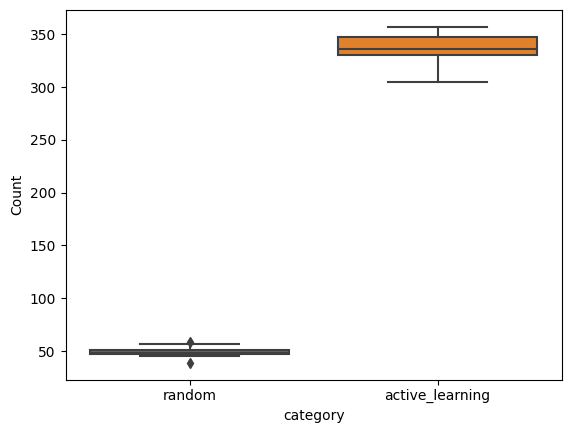

In [103]:
# Plotting the results of AL vs random search
# Making a dataframe from the random list
random_df = pd.DataFrame(random_hit_list)
# Renaming only column of dataframe
random_df.columns = ["Count"]
# Adding a category column and assigning the values to random
random_df["category"] = "random"

# Making a dataframe from the active learning
active_df = pd.DataFrame(active_learning_hit_count_list)
# Renaming only column of dataframe
active_df.columns = ["Count"]
# Adding a category column and assigning the values to active learning
active_df["category"] = "active_learning"

# Concatenating the two dataframes for plotting
rand_AL_df = pd.concat([random_df, active_df])

sns.boxplot(data=rand_AL_df, x="category", y="Count")

In [106]:
# Calculating enrichment ration of AL vs random
np.mean(active_learning_hit_count_list) / np.mean(random_hit_list)


6.837398373983739